# Install Libaries

In [ ]:
!pip install pymc-marketing
!pip install lifetimes

# Import Lib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from arviz.labels import MapLabeller
from pymc_marketing import clv
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Constants

In [3]:
data_path:str = "http://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx"
observed_period:int = 373

# Reads data

UCI ML Repository - [Online Retail II](https://archive.ics.uci.edu/dataset/502/online+retail+ii)

In [4]:
# Reads data and rename colum id
raw_data:pd.DataFrame = pd.read_excel(data_path)
raw_data.rename({"Customer ID":"Customer_ID"}, axis=1, inplace=True)

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer_ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


# Transforms data

## Clean database

In [5]:
# Select nan customer_id
nan_customer_id:pd.DataFrame = raw_data[raw_data['Customer_ID'].isna()].index

# Select cacelled oders
cancelled_orders:pd.DataFrame= raw_data[
    raw_data['Invoice'].astype(str).str.startswith("C")
].index

# Union all rows to drop
rows_to_drop = nan_customer_id.union(cancelled_orders)

# Drop rows from database
raw_data.drop(rows_to_drop, inplace=True)

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 407695 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      407695 non-null  object        
 1   StockCode    407695 non-null  object        
 2   Description  407695 non-null  object        
 3   Quantity     407695 non-null  int64         
 4   InvoiceDate  407695 non-null  datetime64[ns]
 5   Price        407695 non-null  float64       
 6   Customer_ID  407695 non-null  float64       
 7   Country      407695 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 28.0+ MB


## RFM Matrix

In [6]:
# Creates date column
raw_data['date'] = pd.to_datetime(raw_data['InvoiceDate'].dt.date)

# Calculate RFM matrix
rfm_data:pd.DataFrame = clv.utils.rfm_train_test_split(
    transactions= raw_data,
    customer_id_col= "Customer_ID",
    datetime_col= "date",
    monetary_value_col="Price",
    train_period_end= "2010-11-30",
    test_period_end= "2010-12-09",
    time_unit= "D"
)

In [27]:
rfm_data.head()

,customer_id,frequency,recency,T,monetary_value,test_frequency,test_monetary_value,test_T,expected_purchases_mean,expected_spend,future_spend
0,12346.0,6.0,196.0,351.0,32.143333,0.0,0.00,9.0,0.142827,47.662017,47.662017
1,12347.0,0.0,0.0,30.0,0.000000,1.0,89.59,9.0,0.077283,74.798697,74.798697
2,12348.0,0.0,0.0,64.0,0.000000,0.0,0.00,9.0,0.056952,74.798697,74.798697
3,12349.0,2.0,182.0,215.0,340.380000,0.0,0.00,9.0,0.090185,172.658521,172.658521
4,12351.0,0.0,0.0,1.0,0.000000,0.0,0.00,9.0,0.111136,74.798697,74.798697


# BG/NBD Model
Predicting Future Purchasing Behavior

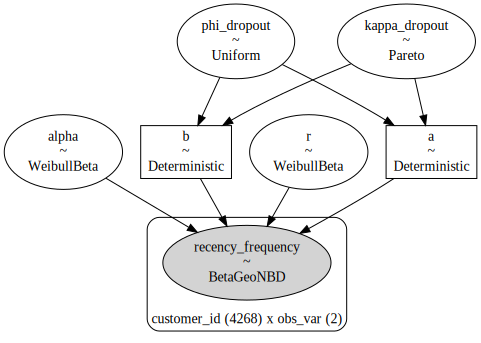

In [8]:
bgm = clv.BetaGeoModel(data=rfm_data)

bgm.build_model()
bgm.graphviz()

In [9]:
bgm.fit()
bgm.fit_summary()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.033,0.139,0.000,0.082,0.004,0.040,1089.0,625.0,1.00
alpha,65.256,2.243,61.357,69.509,0.068,0.048,1100.0,1279.0,1.00
b,15.516,85.982,0.992,39.177,2.598,27.132,1289.0,1137.0,1.00
kappa_dropout,15.549,86.114,1.003,39.359,2.602,27.173,1285.0,1129.0,1.00
phi_dropout,0.003,0.002,0.000,0.007,0.000,0.000,1176.0,946.0,1.00
r,0.818,0.024,0.774,0.864,0.001,0.001,1097.0,1033.0,1.01


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

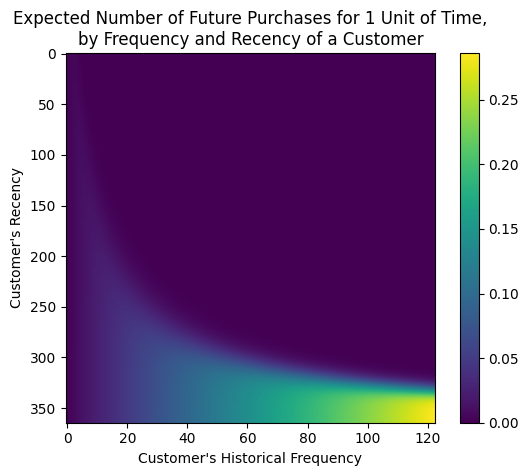

In [10]:
clv.plot_frequency_recency_matrix(bgm)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

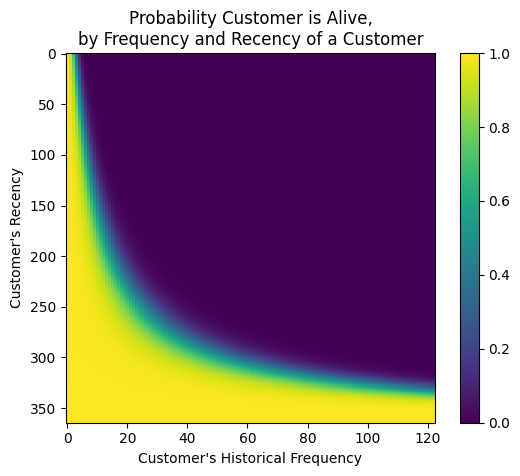

In [11]:
clv.plot_probability_alive_matrix(bgm)

## Expected purchases

In [12]:
# Select holdout time to predict
future_t_holdout = rfm_data['test_T'].values

# Predict futerue purchase
num_purchases = bgm.expected_purchases(future_t= future_t_holdout)
expected_purchases_mean = num_purchases.mean(dim=("chain", "draw")).values

rfm_data['expected_purchases_mean'] = expected_purchases_mean

## Evaluate

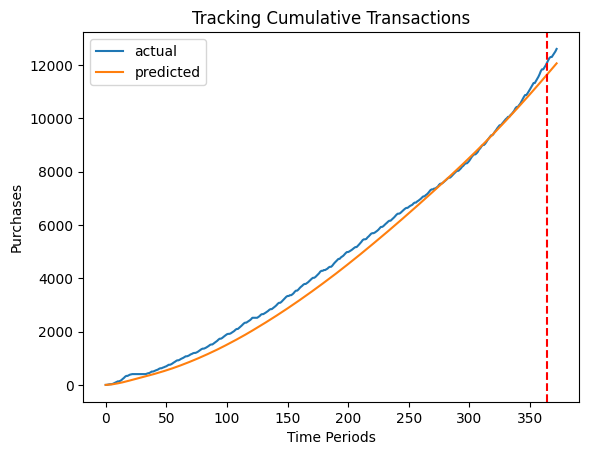

In [13]:
clv.plot_expected_purchases_over_time(
    model=bgm,
    purchase_history=raw_data,
    datetime_col="date",
    customer_id_col="Customer_ID",
    datetime_format="%Y%m%d",
    time_unit="D",
    t=observed_period,
    t_start_eval= 364
);

In [14]:
# Remover NaNs se houver (pode acontecer se houver clientes sem histórico suficiente)
rfm_eval = rfm_data.dropna(
    subset=['test_frequency', 'expected_purchases_mean']
)

y_true = rfm_eval['test_frequency']
y_pred = rfm_eval['expected_purchases_mean']
mean_absolute_error(y_true, y_pred)

0.19347363703002057

# Gamma-Gamma Model

In [15]:
nonzero_rfm_data = rfm_data.query("frequency>0")

nonzero_rfm_data[["monetary_value", "frequency"]].corr()

,monetary_value,frequency
monetary_value,1.000000,0.025183
frequency,0.025183,1.000000


In [16]:
gg = clv.GammaGammaModel(data=nonzero_rfm_data)
gg.build_model()
gg

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [17]:
gg.fit()
gg.fit_summary()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.823,0.034,0.761,0.887,0.002,0.001,457.0,693.0,1.0
q,3.832,0.251,3.376,4.311,0.012,0.008,460.0,578.0,1.0
v,258.133,27.296,209.796,309.180,1.393,0.831,383.0,506.0,1.0


## Expected spend

In [18]:
# Predict futerue purchase
expected_spend = gg.expected_customer_spend(data=rfm_data)

expected_spend_mean:np.array = expected_spend.mean(dim=("chain", "draw")).values

rfm_data['expected_spend'] = expected_spend_mean

## Evaluate

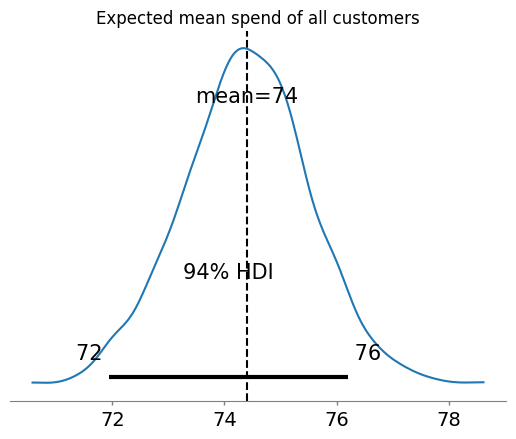

In [19]:
az.plot_posterior(expected_spend.mean("customer_id"))
plt.axvline(expected_spend.mean(), color="k", ls="--")
plt.title("Expected mean spend of all customers");

In [20]:
# Remover NaNs se houver (pode acontecer se houver clientes sem histórico suficiente)
rfm_eval = rfm_data.query("frequency>0")

y_true = rfm_eval['test_frequency']
y_pred = rfm_eval['expected_purchases_mean']
mean_absolute_error(y_true, y_pred)

0.25417103101587535

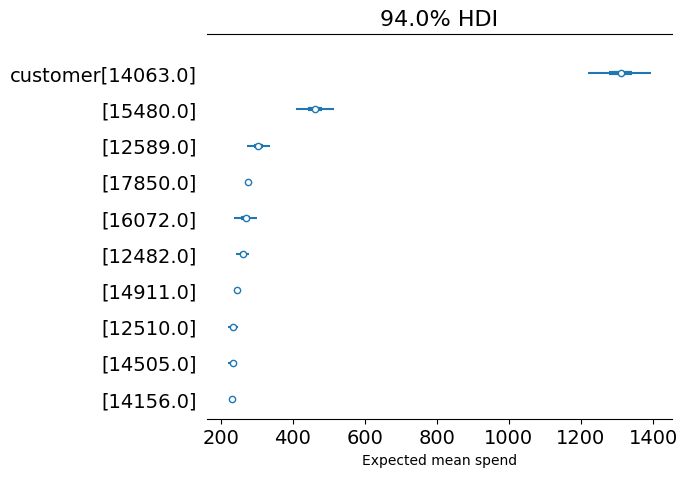

In [21]:
# Map labels
labeller = MapLabeller(var_name_map={"x": "customer"})

# Sort constumers with the best mean
sorted_customer_ids = expected_spend.mean(dim=["chain", "draw"])\
                                     .to_series()\
                                     .sort_values(ascending=False)\
                                     .index[:10]

# Select posterior
sorted_posterior_data = expected_spend.sel(customer_id=sorted_customer_ids)

# Plot top 10 constumers
az.plot_forest(
    sorted_posterior_data,
    combined=True,
    labeller=labeller,
)
plt.xlabel("Expected mean spend");

# CLV

In [22]:
%%time
clv_estimate = gg.expected_customer_lifetime_value(
    transaction_model=bgm,
    data=rfm_data,
    future_t=9,
    discount_rate=0.01,
    time_unit="D"
)

CPU times: user 31 s, sys: 4.69 s, total: 35.7 s
Wall time: 35.9 s


## Evaluate

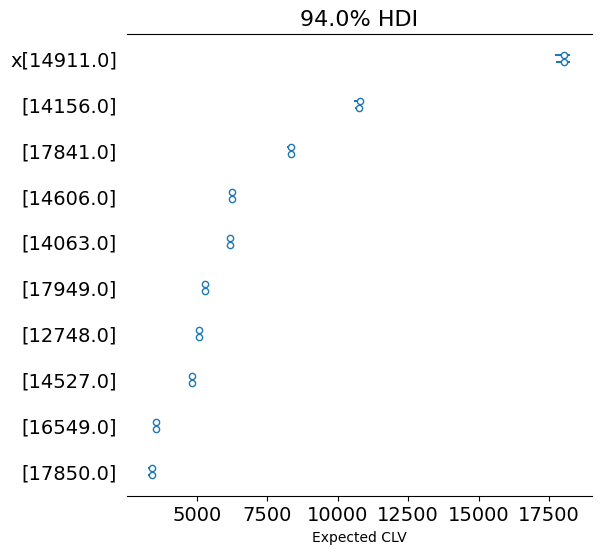

In [23]:
# Map labels
labeller = MapLabeller(var_name_map={"x": "customer"})

# Sort constumers with the best mean
sorted_customer_ids = clv_estimate.mean(dim=["chain", "draw"])\
                                     .to_series()\
                                     .sort_values(ascending=False)\
                                     .index[:10]

# Select posterior
sorted_posterior_data = clv_estimate.sel(customer_id=sorted_customer_ids)

az.plot_forest(sorted_posterior_data)
plt.xlabel("Expected CLV");

In [24]:
#!jupyter nbconvert --to html /content/esalq_cslv.ipynb


Modelo Gamma-Gamma e Valor Monetário Esperado
Complementando a análise, o modelo Gamma-Gamma foi aplicado para prever o valor monetário das transações futuras esperadas por cliente. A Tabela 4 mostra as estimativas médias de gasto por cliente, indicando aqueles com potencial de alto retorno financeiro.


Estimativa do Customer Lifetime Value (CLV)
Por fim, a combinação dos resultados dos modelos BG/NBD e Gamma-Gamma possibilitou o cálculo da métrica final de Customer Lifetime Value (CLV). A Tabela 4 apresenta uma classificação dos clientes segundo o valor esperado ao longo do tempo, destacando claramente aqueles que geram maior valor à organização.
(Inserir aqui a Tabela 4 com resultados combinados dos modelos para estimativa do CLV)

Esses resultados demonstram a importância estratégica do uso integrado desses modelos para tomada de decisões fundamentadas em dados, possibilitando investimentos mais assertivos em retenção e aquisição de clientes, além de estratégias personalizadas de marketing.